In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
data_folder = os.path.join('..', 'data')
file_name = "Data"

# Long term form

Knowing the long term form of the teams playing in the match can be very significant in deciiding the outcome. Good teams have often been good for a long time and have the resources and infrastructure to stay good. We should then implement a system to keep track of this expected strength difference.

## ELO Rating

To model the strength of each team playing, we will use the ELO Rating System. The ELO rating is a statistical system to rate two players in a zero-sum game. Originially it was created for chess, but it can be used for any two-player game. 

### How it works

The key concept is that each player has a rating, represented by a number. In reality it representes the mean for a gaussian distribution. After each game, the rating of both players is updated to reflect the game outcome. The update is based on the expected probability of each player winning, which depends on the difference between their current ratings. The original ELO system only handled wins and losses, however we use a version which can account for the possibility of draws.

### Expected score Calculation

The difference in rating between the two teams, team A and team B, can be used to calculate a probability of the three possible outcomes. Firstly, the probiabilities without draws must be calculated. This is done using the logistic function:

$$
E_A = \frac{1}{1 + 10^{\frac{R_B - R_A}{400}}}
$$

where:
- $ E_A $ is the expected score for player $ A $,
- $ R_A $ is the current rating of player $ A $,
- $ R_B $ is the current rating of player $ B $.

Similarly, the expected score for player $ B $ is:

$$
E_B = \frac{1}{1 + 10^{\frac{R_A - R_B}{400}}}
$$

Note that $ E_A + E_B = 1 $, which means the sum of both players' expected scores is always 1.

To implement draws, we use a draw-factor, which representes the expected probability of a draw. We represent it by $ D $. Now to calculate the probabilites for a Team A winning, a draw or Team B winning, we use the following formulas:
$$
E_D = D \cdot (1 - {|E_A - E_B|})
$$

$$
E'_A = \frac{1}{1 + 10^{\frac{R_B - R_A}{400}}} - E_D/2
$$

$$
E'_B = \frac{1}{1 + 10^{\frac{R_A - R_B}{400}}} - E_D/2
$$



Now, $ E'_A + E'_B + E_D = 1 $, which means the sum of all three expected scores is always 1.

### Rating update

After a match, the ratings the two teams are updated based on tha actual outcome of the match, and the probability of the outcome. If team $A$ wins, $S_A = 1$ and $S_B = 0$. If team $B$ wins, $S_A = 0$ and $S_B = 1$. If the match ends in a draw $S_A = 0.5$ and $S_B = 0.5$. Another variable, the K-factor is used, denoted by $K$. The K-factor is used to decide the how much a match affects the rating change. Normally, it starts high and decreases as more games have been played. However, in our case we will use the most common value $K=32$. The new ratings are calculated as follows:

$$
R_{A_{new}} = R_A + K \cdot (S_A - (E'_A+E_D/2))
$$
$$
R_{B_{new}} = R_B + K \cdot (S_B - (E'_B+E_D/2))
$$

### Our Implementation

To start, we must decide the draw-factor, the k-factor, and give each team an initial rating. We get the draw factor from the collection of games. We set the k-factor to 32. The teams in the different division only play each other until some are promoted or relegated. Each division does signify the strength level, as the Premier League is stronger than the Championship. To account for this, we will give the teams starting in the Premier League an initial rating of 1500. For each division below, we will decrease the rating by 200. Additionally, as we uncovered the team playing at home has an advantage. To account for this we will add 50 to the home team when calculating the probabilites, which will approximate the advantage shown in the original data.

#### Load Data

In [2]:
data = util.load_data(data_folder, file_name)
data = util.clean_data(data)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,E0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,...,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,0506
1,E0,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,...,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,0506
2,E0,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,...,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,0506
3,E0,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,...,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,0506
4,E0,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,...,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,0506


In [3]:
home_factor, draw_factor, away_factor = data['FTR'].value_counts(normalize=True)['H'], data['FTR'].value_counts(normalize=True)['D'], data['FTR'].value_counts(normalize=True)['A']
home_factor, draw_factor, away_factor

(np.float64(0.4345732358070646),
 np.float64(0.2645443423484395),
 np.float64(0.30088242184449593))

### ELO Implementation

To use the ELO system, we will iterate over all matches, adding columns to describe the rating for the Home Team, the away team, the difference (which is important for probabilties), and the corresponding probabilites of outcome.

In [4]:
ELO = util.ELO(data, init_rating=1500, draw_factor=draw_factor, k_factor=32, home_advantage=50)
data = ELO.perform_simulations(data)
data = ELO.get_probabilities(data)
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AY,HR,AR,Season,Home ELO,Away ELO,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO
0,E0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,...,2.0,0.0,0.0,0506,1500.000000,1500.000000,0.000000,0.458096,0.226734,0.315170
1,E0,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,...,1.0,0.0,0.0,0506,1500.000000,1500.000000,0.000000,0.458096,0.226734,0.315170
2,E0,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,...,2.0,0.0,0.0,0506,1500.000000,1500.000000,0.000000,0.458096,0.226734,0.315170
3,E0,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,...,3.0,0.0,0.0,0506,1500.000000,1500.000000,0.000000,0.458096,0.226734,0.315170
4,E0,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,...,3.0,1.0,0.0,0506,1500.000000,1500.000000,0.000000,0.458096,0.226734,0.315170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38412,E3,2024-04-27,Gillingham,Doncaster,2.0,2.0,D,0.0,2.0,A,...,1.0,0.0,1.0,2324,893.815522,1005.019484,-111.203962,0.303611,0.218419,0.477970
38413,E3,2024-04-27,Milton Keynes Dons,Sutton,4.0,4.0,D,2.0,0.0,H,...,2.0,0.0,0.0,2324,999.415559,852.030130,147.385429,0.692702,0.128574,0.178724
38414,E3,2024-04-27,Salford,Harrogate,2.0,2.0,D,2.0,2.0,D,...,2.0,0.0,0.0,2324,855.948884,903.431102,-47.482218,0.372310,0.262627,0.365063
38415,E3,2024-04-27,Swindon,Morecambe,3.0,3.0,D,2.0,2.0,D,...,0.0,0.0,0.0,2324,835.942841,869.551086,-33.608246,0.397536,0.252073,0.350392


For context, let's look at how Liverpool, one of the top teams, has performed over their previous matches.

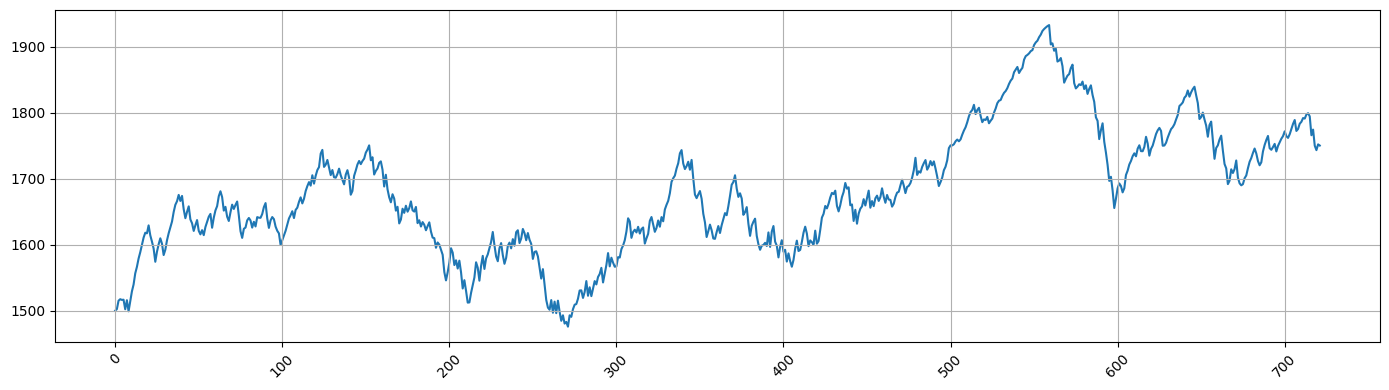

In [5]:
ELO_Liverpool = util.extract_elo_history(data, 'Liverpool')
util.plot_series(ELO_Liverpool['ELO'], figsize=figsize)

Looking at it with years, we get a more ugly plot, but it shows the form over the years. We can for instance see when Liverpool won the league, in 19/20.

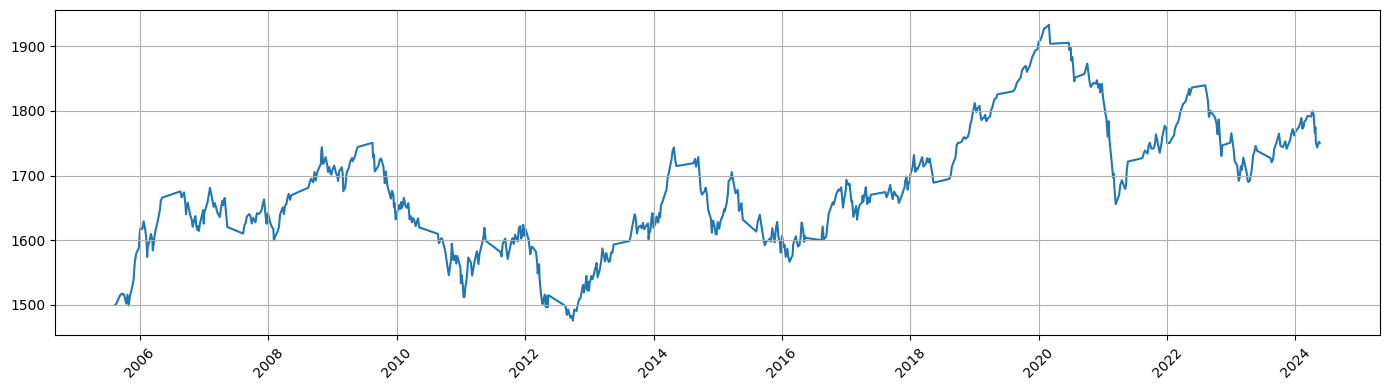

In [6]:
ELO_Liverpool.set_index('Date', inplace=True)
util.plot_series(ELO_Liverpool['ELO'], figsize=figsize)

For there to be any predictive power, there should be som correlation between the difference in ELO rating between the two teams, and the actual outcome. We can look at a correlation matrix to see if this is the case.

In [7]:
data = pd.get_dummies(data, columns=["FTR"])
data[['FTR_H', 'FTR_D', 'FTR_A', 'ELO diff']].corr()

,FTR_H,FTR_D,FTR_A,ELO diff
FTR_H,1.000000,-0.525792,-0.575131,0.227630
FTR_D,-0.525792,1.000000,-0.393454,-0.027818
FTR_A,-0.575131,-0.393454,1.000000,-0.219270
ELO diff,0.227630,-0.027818,-0.219270,1.000000


### Using the probabilites

Now, let's use the probabilites obtained by the ELO system to predict outcomes, like we did in the previous notebook.

In [8]:
data['Home Prob'] = data['Home_prob_ELO']
data['Draw Prob'] = data['Draw_prob_ELO']
data['Away Prob'] = data['Away_prob_ELO']

In [9]:
correct, wrong = util.pick_highest_probabilites(data)
print(f'The model correctly predicted {correct} matches and incorrectly predicted {wrong} matches.')
print(f'The model picks {correct/(correct+wrong)*100:.2f}% outcomes correctly.')

The model correctly predicted 17880 matches and incorrectly predicted 20538 matches.
The model picks 46.54% outcomes correctly.


With ELO, there is a slight improvement. Let's also look at a way to use short term form to predict outcomes, by creating a Match Rating.